# `SVR` Regression using `sklearn`

Using the tunned parameters from [Young and others](https://www.cambridge.org/core/journals/journal-of-glaciology/article/an-imbalancing-act-the-delayed-dynamic-response-of-the-kaskawulsh-glacier-to-sustained-mass-loss/350065B3C0CD9A900DCBA7D60445D583) (2021), Eriks ran his model for Little Kluane for $2007-2018$. Using the time averaged rasters from Eriks model runs we want to fit an regression to his data to be used in to generate "sythetic" Little Kluane's in `Elmer/Ice` for Alexi to asses the preformance of his inversion procedure. Based on some back and forth the `#glacier-bed-inversions` channel (on 03/02/2021), we have decided to use a Supprt Vector Regression implemented throught rhe `sklearn` module. 

In [1]:
import time 
import numpy as np 
import matplotlib.pyplot as plt 

import pickle
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

plt.rcParams['text.usetex'] = True 

In [2]:
MB  = np.load('../Data/SMB/EMY_data/surgio_withdeb_NMB.npy') # annual mass balance data from EMY
ZZ  = np.load('../Data/SMB/EMY_data/surgio_Zs.npy')          # Elevation used by EMY

# Take temporal average of mb data and convert from mwe a^{-1} to m a^{-1}
MB  = np.mean(MB,axis=0)*1000.0/910.            # Annual mean mass balance in [m a^{-1}]


The regression won't be able to handle `nans` so lets remove all the `nan`s from the raster, flatten it to a column vector, and remove an outliers.

In [3]:
# Get rid of nans and outlier
z   = ZZ[(~np.isnan(MB)) & ~(MB < -10)]
b   = MB[(~np.isnan(MB)) & ~(MB < -10)] 

For the regression our data needs to be sorted, so let's sort both elevation ($z$) and $\dot b$ based on $z$. Furthermore, the `X` vector (the dependent variable in regression) needs to be a column vector for `sklearn`, so let's reshape that aswell. 

In [4]:
#return the indexes of the sorted arrays
idx = z.argsort()

#sort the arrays based on the elevation
z   = z[idx].reshape(-1,1)
b   = b[idx]    

Support Vector Regression (`SVR`) is an extension of support vector classification. From the `sklearn` user guide for `SVR`:  

> ...the model produced by Support Vector Regression depends only on a subset of the training data, because the cost function ignores samples whose prediction is close to their target.

Therefore, to speed computational effiency we should split our data into training and testing sets. Since `SVR` only depends of a subbset of the data, we should only need to use a fairly small portion of the data as the training data. 

__Note :__ `SVR` is not scale invariant. We may want/need to normalize the data as described [here](https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use). 

In [5]:
z_train, z_test, b_train, b_test \
    = train_test_split(z, b, train_size=0.3, random_state=1)

There are multiple options for the kernel used to determine the weights: Linear, polynomial, and radial basis functions. Without having seriously tested other kernel options, it seems like we are leaning towards using a radial basis function `RBF` for our kernel. We can test other kernel option later if need be.  

When using a `RBF` kernel, the two hyperparameters in the model tuning are `C` and `gamma`. From the `sklearn` [user guide on `SVR`](https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel):

> The parameter `C`, common to all `SVM` kernels, trades off misclassification of training examples against simplicity of the decision surface. 
>A low `C` makes the decision surface smooth, while a high `C` aims at classifying all training examples correctly. 
> `gamma` defines how much influence a single training example has. The larger `gamma` is, the closer other examples must be to be affected.

Therefore let's use [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) to fit the hyperparameters `C` and `gamma`. 

In [6]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C"    : np.geomspace(1e-3, 1e2, 6),
                               "gamma": np.geomspace(1e-6, 1e0, 7)})

Lets fit our model over the defined hyperparamter grid and record the time it takes to fit our hyperparameters. 

In [7]:
t0 = time.time()
svr.fit(z_train, b_train);
svr_fit = time.time() - t0

print("SVR complexity and bandwidth selected and model fitted in {:.3f} s".format(svr_fit))

SVR complexity and bandwidth selected and model fitted in 54.841 s


`SVR` will only use a subset of the training data as support vectors. The number of support vectors will be dependent upon the optimal value of parameter `C`, since "trades off misclassification of training examples against simplicity of the decision surface". Therefore lets see what fraction of the training set was used as support vectors for the `best_estimator_`: 

In [8]:
sv_ratio = svr.best_estimator_.support_.shape[0] / z_train.shape[0]
print("Support vector ratio: {:.3f}".format(sv_ratio))

Support vector ratio: 0.519


Now, using the best hyperparamters from the cross validation grid search, lets fit the model.  

In [9]:
b_hat = svr.predict(z)

Lets take a look at our results: 

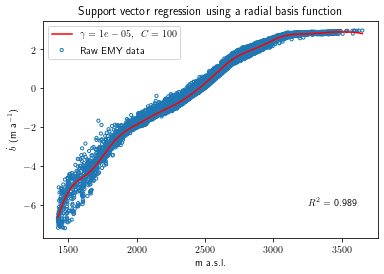

In [10]:
fig, ax = plt.subplots(1,1)

ax.scatter(z, b, marker='o', s=10,  facecolor="none", edgecolor='tab:blue', label='Raw EMY data')
ax.plot(z,b_hat,color='r', 
        label = '$\gamma = {{{:1.0e}}}, \;\; C = {{{:3.0f}}}$'.format(svr.best_estimator_.gamma, svr.best_estimator_.C))
ax.legend()

ax.text(3250, -6, '$R^2$ = {:1.3f}'.format(svr.best_estimator_.score(z,b)))

ax.set_title('Support vector regression using a radial basis function')
ax.set_ylabel('$\dot b$ (m a$^{-1}$)')

ax.set_xlabel('m a.s.l.')

fig.savefig('../plots/svr_regression.png', dpi=400, bbox_inches='tight',facecolor='w')

How about the residuals? 

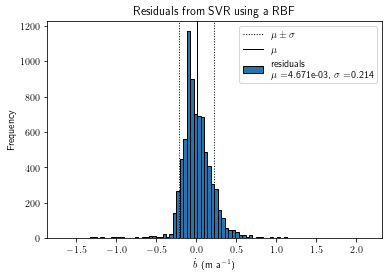

In [11]:
fig, ax = plt.subplots(1,1)

mu  = np.mean(b-b_hat)
std = np.std(b-b_hat,ddof=1)

#######################################################################
# Plot residuals
#######################################################################
_ = ax.hist(b-b_hat,
            bins=np.sqrt(len(b)).astype(int), 
            edgecolor='k', 
            label = 'residuals \n $\mu=${:1.3e}, $\sigma=${:2.3f}'.format(mu, std))

mu  = np.mean(b-b_hat)
std = np.std(b-b_hat,ddof=1)

ax.axvline(mu-std, ls=':', c='k', lw=1, label='$\mu \pm \sigma$')
ax.axvline(mu,     ls='-', c='k', lw=1, label='$\mu$')
ax.axvline(mu+std, ls=':', c='k', lw=1)

ax.set_title('Residuals from SVR using a RBF')
ax.set_ylabel('Frequency')
ax.set_xlabel('$\dot b$ (m a$^{-1}$)')

ax.legend()

fig.savefig('../plots/svr_regression_residual.png', dpi=400, bbox_inches='tight',facecolor='w')

Great! Final step will be saving (serializing) our fitted model so we can use it later down the line. We'll do our serialization with `pickle`, but we may want to switch to `joblib` for the sake of effiency. For more info see [here](https://scikit-learn.org/stable/modules/model_persistence.html) or [here](https://stackabuse.com/scikit-learn-save-and-restore-models/). 

In [13]:
pkl_fn = "../Data/SMB/SVR/svr_model.pkl"

# write the file 
with open(pkl_fn, 'wb') as file:
    pickle.dump(svr, file)

Now, the serialized model will be great when working in `python`, but of no use from `Elmer/Ice` or `Fortran` during simulations. 
Therefore, we need to the predictions ourselves using the support vectors $SV$, the dual coefficents $\alpha_i - \alpha_i^*$, and the independent term  $b$. Therefore, we will need to make predictions ($\hat y$) such that: 

$$
\hat y = \sum_{i \in SV}(\alpha_i - \alpha_i^*) K(x_i, x) + b
$$

where $SV$ are support vectors (storred in attribute `support_vectors_`), $\alpha_i - \alpha_i^*$ are our dual coeffiecents (storred in attribute `dual_coef_`), $b$ is the intercept (storred in attribute `intercept_`), and `K(x_i, x)` is the kernel. Ther kernel $K(x_i, x)$ takes as input $x_i$; the $i$-th $SV$ and $x$; the vector of points where we want to make predictions. We use a radial basis kernel for our SVR, of the from: 
$$
\exp(-\gamma \|x-x'\|^2), 
$$
where $x$ are our support vectors and $x'$ are the locations where we want to make predictions. 

The vectorized form of this caculation is python is as follows: 

In [14]:
test = np.dot(svr.best_estimator_.dual_coef_, 
    np.exp(-svr.best_estimator_.gamma * np.abs(svr.best_estimator_.support_vectors_ - z.T)**2)) + svr.best_estimator_.intercept_

We can confirm this manual prediction is correct by looking at the $L2$ norm of the difference between `sklearn`'s prediction and our own: 

In [15]:
np.linalg.norm(b_hat - test)

8.082075799653907e-11

We can do this as a vectorized oppperation in `FORTRAN` using the intrinsic fucntion `SPREAD` but this is of limited use to us when trying to assign values in Elmer. The most strait forward way to assign/calculate boundary values (i.e. field values along a boundary (e.g. surface)) is to loop over all the nodes. Therefore, lets figure out how to do this calculation nodally (i.e. at one point at a time): 

In [16]:
# Save the support vectors
np.savetxt('../Data/SMB/SVR/support_vectors.dat',
          svr.best_estimator_.support_vectors_[:,0])

# Save the dual coefficents
np.savetxt('../Data/SMB/SVR/dual_coef.dat',
         svr.best_estimator_.dual_coef_[0,:])

print('\gamma   :', svr.best_estimator_.gamma)
print('interecpt:', svr.best_estimator_.intercept_[0])

\gamma   : 1e-05
interecpt: -1.2393076753413321


In [17]:
np.matmul(svr.best_estimator_.dual_coef_,
         np.exp(-svr.best_estimator_.gamma * np.abs(svr.best_estimator_.support_vectors_ - z[-1])**2)) + svr.best_estimator_.intercept_

array([[2.79960278]])

In [18]:
#y_hat_fortan = np.loadtxt('../Data/SVR/fortran_svr_prediction.dat')[:,1]

In [19]:
#np.linalg.norm(b_hat - y_hat_fortan)

In [20]:
#plt.plot(b_hat)
# _ = plt.hist(b_hat - y_hat_fortan, bins=np.sqrt(test.shape[1]).astype(np.int))
# _ = plt.hist(b_hat - test[0,:], bins=np.sqrt(test.shape[1]).astype(np.int))


In [21]:
!head '../Data/SMB/SVR/dual_coef.dat'

-1.000000000000000000e+02
1.000000000000000000e+02
1.000000000000000000e+02
1.000000000000000000e+02
1.000000000000000000e+02
1.000000000000000000e+02
-1.000000000000000000e+02
-1.000000000000000000e+02
1.000000000000000000e+02
1.000000000000000000e+02


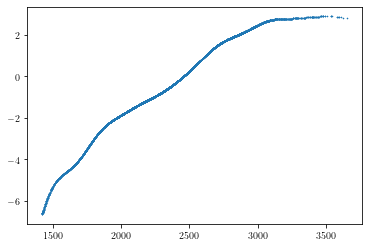

In [22]:
plt.plot(z, b_hat, 'x', markersize=1)

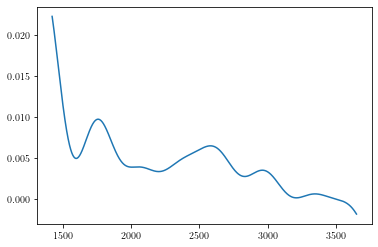

In [23]:
Z, dZ = np.linspace(z.min(),z.max(),10000, retstep=True)
b_hat = svr.predict(Z[:,np.newaxis])

plt.plot(Z, np.gradient(b_hat.ravel(), dZ))